# Questions: 

Is there a relationship between favorite count and rating, ie more favorite tweets have higher WeRateDogs ratings?
Which type of dog do people like the most, ie which dog type is most favorite? Which dog name is most popular and do they have the highest rating?

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import urllib.request
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

In [2]:
# set auth tokens for new twitter api instance
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [3]:
# create new instance of tweepy.API object
api = tweepy.API(auth)

In [4]:
# read in twitter-archive-enhanced directly from memory
df = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
# get image_predictions.tsv from server as request object
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [6]:
# write image_predictions object to file
with open('image_predictions.tsv', 'wb') as f:
    f.write(r.content)

In [7]:
# read in image_predictions.tsv with pandas read_csv function using \t delimiter option
df2 = pd.read_csv('image_predictions.tsv', sep='\t')

In [8]:
# create ndarray of tweet_id's to be used later when getting tweet objects via Twitter API
tweet_ids = df.tweet_id.values
tweet_ids

array([892420643555336193, 892177421306343426, 891815181378084864, ...,
       666033412701032449, 666029285002620928, 666020888022790149],
      dtype=int64)

In [9]:
# Code for creating tweet json objects via Twitter API and writing them to text file
count = 0
fails_dict = {}
start = timer()

with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        # Print a count and tweet_id of where we are in the list so we know the program is still running
        print(str(count) + ": " + str(tweet_id))
        try:
            # Access Twitter API - since there is a 15 minute wait once rate_limit is reached
            # set the wait_on_rate_limit option to True 
            tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True)
            print("Success")
            # write json object to file
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            # dict of API calls that failed and their error messages
            fails_dict[tweet_id] = e
            pass

# For good measure, let's time the operation
end = timer()
print(end - start)
# Print tweet_id's and error messages of failed attempts 
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [10]:
# new DataFrame to store tweets from json file
df3 = pd.DataFrame()

# Since json.loads can not read multiple objects, we have to find another workaround
# We are going to load each json object line by line, flatten it with pandas, then append to the new DataFrame 
with open('tweet_json.txt') as json_file:
    for line in json_file.readlines():
        # load single json object from json file which contains multiple json objects 
        json_data = json.loads(line)
        # flatten the json object
        new_record = pd.json_normalize(json_data)
        # concat the flattened json object onto the dataframe
        df3 = pd.concat([df3, new_record], ignore_index=True)

# reset the index to match the original json_file object order
df3.reset_index(inplace=True, drop=True)

## Assess
#### Quality
twitter_archive_enhanced.csv
1. Inconsistent rating_numerator. Looks like the real max rating is around 14.  
2. Inconsistent rating_denominator. Value should be "10". Around 20 of these values are inconsistent. 
3. There are tweets that are not dogs.
4. Some posts no longer exist, so our analysis would not be able to be reproduced if we include these. 
5. tweet_id is an int64. We can make this a str object since we won't be performing calculations on it.
6. Some of the values in the names column do not make any sense, ie some names are 'a', 'the', or 'None'.

#### Tidiness
1. Some postings are retweets. We can get rid of those
2. Some postings are "in reply to". We can get rid of those 
3. Rename tweet_id to id<br><br>
Let's pull out tweet_id, full_text, rating_numerator, rating_denominator, and name

In [11]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
# this shows that some in_reply_to_status_id and retweeted_status_id are not null, meaning we want to eliminate these
# this also shows that the datatype of tweet_id is an int64, we want a str object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
# check rating_numerator values
df.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [14]:
# check rating_denominator values
df.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [15]:
# found an observation that is a Snoop Dog instead of an actual dog
df[df.rating_numerator == 420]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None


In [16]:
# Shows that we have 'a' as a dog name for 55 observations, which doesn't make any sense.
# Also 'the' and 'None' which won't be useful for our analysis
dict(df.name.value_counts())

{'None': 745,
 'a': 55,
 'Charlie': 12,
 'Oliver': 11,
 'Cooper': 11,
 'Lucy': 11,
 'Lola': 10,
 'Tucker': 10,
 'Penny': 10,
 'Bo': 9,
 'Winston': 9,
 'Sadie': 8,
 'the': 8,
 'Toby': 7,
 'Daisy': 7,
 'Bailey': 7,
 'an': 7,
 'Buddy': 7,
 'Rusty': 6,
 'Dave': 6,
 'Stanley': 6,
 'Jack': 6,
 'Leo': 6,
 'Oscar': 6,
 'Jax': 6,
 'Bella': 6,
 'Scout': 6,
 'Milo': 6,
 'Koda': 6,
 'Sunny': 5,
 'Chester': 5,
 'Gus': 5,
 'very': 5,
 'Sammy': 5,
 'Oakley': 5,
 'Alfie': 5,
 'Phil': 5,
 'Louis': 5,
 'Finn': 5,
 'Larry': 5,
 'Bentley': 5,
 'George': 5,
 'Jerry': 4,
 'Shadow': 4,
 'Sophie': 4,
 'Scooter': 4,
 'Bear': 4,
 'Jeffrey': 4,
 'Carl': 4,
 'Winnie': 4,
 'Archie': 4,
 'Gerald': 4,
 'Loki': 4,
 'Bruce': 4,
 'Sampson': 4,
 'Boomer': 4,
 'Luna': 4,
 'Duke': 4,
 'Maximus': 4,
 'Clarence': 4,
 'Reginald': 4,
 'Beau': 4,
 'just': 4,
 'Brody': 4,
 'Walter': 4,
 'Moose': 4,
 'Gary': 4,
 'Riley': 4,
 'quite': 4,
 'Ruby': 4,
 'Dexter': 4,
 'Reggie': 4,
 'one': 4,
 'Cassie': 4,
 'Clark': 4,
 'Hank': 4,
 'D

## Assess
#### Quality
image_predictions.tsv
1. tweet_id is an int64. We can make this a str object since we won't be performing calculations on it.
2. There are predictions that are not dogs. Let's get rid of those.
3. Dog types in p1, p2 and p3 have inconsistent case, ie 'redbone' is lower and German_shephard is upper
4. Inconsistent spelling, ie "Shih-Tzu" contains a hyphen. Let's get rid of this.

#### Tidiness
1. Rename tweet_id to id. 
2. For our analysis we will only need our number 1 dogs with p1_conf greater than 0.95 so we can get rid of everything else.

In [17]:
# dog type prediction based on image in tweet
df2.head(20) 

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
# checking for max or min values for p1_conf that might not be between 0 and 1. Looks good
df2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


## Assess
tweet_json.txt

#### Quality
Quality looks good for our analysis. Not much to clean. 

#### Tidiness
1. Much of this data is not relevant to our analysis, ie there are 322 variables. We only need id, retweet_count, and favorite_count from this dataset. Get what we need and then reassess.
2. Rename id_str to id

In [20]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Columns: 322 entries, created_at to place.bounding_box.coordinates
dtypes: bool(18), float64(29), int64(9), object(266)
memory usage: 5.4+ MB


In [21]:
df3[['id_str', 'retweet_count', 'favorite_count']].head()

,id_str,retweet_count,favorite_count
0,892420643555336193,7555,35734
1,892177421306343426,5599,30873
2,891815181378084864,3709,23224
3,891689557279858688,7739,39026
4,891327558926688256,8335,37282


In [33]:
# check for duplicate observations
print(df.duplicated().any().any())
print(df2.duplicated().any().any())
print(df3['id_str'].duplicated().any())

False
False
False


# Clean

In [34]:
# Let's make copies of our data frames before cleaning
tw_enh_clean = df.copy()
img_pred_clean = df2.copy()
tw_api_clean = df3[['id_str', 'retweet_count', 'favorite_count']].copy()

#### Define
Copy a view of DataFrame from tw_enh_clean that only contains rows that have null in_reply_to_status_id and null retweeted_status_id. This will make sure our observations are not reweets or replys. Also grab only columns that we need for analysis.

#### Code

In [35]:
# Let's get rid of retweets and replys
tw_enh_clean = tw_enh_clean[~(tw_enh_clean.in_reply_to_status_id.notnull()) & ~(tw_enh_clean.retweeted_status_id.notnull())]
# Get only variables we care about
tw_enh_clean = tw_enh_clean[['tweet_id', 'rating_numerator', 'rating_denominator', 'name']]

#### Test

In [36]:
# 0 non-null for in_reply_to_status_id and retweeted_status_id
tw_enh_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   rating_numerator    2097 non-null   int64 
 2   rating_denominator  2097 non-null   int64 
 3   name                2097 non-null   object
dtypes: int64(3), object(1)
memory usage: 81.9+ KB


#### Define
Drop observations with rating_numerator > 14, as 14 seems to be the true maximum rating

#### Code

In [37]:
# Get index of the observations that having rating_numerator greater than 14
index = tw_enh_clean[tw_enh_clean.rating_numerator > 14].index
tw_enh_clean.drop(index, inplace=True)

#### Test

In [38]:
# check rating_numerator values
tw_enh_clean.rating_numerator.value_counts().sort_index()

0       1
1       5
2       9
3      19
4      16
5      34
6      32
7      52
8      98
9     153
10    436
11    413
12    486
13    287
14     38
Name: rating_numerator, dtype: int64

#### Define
Drop observations where rating_denominator $\neq$ 10. 

#### Code

In [39]:
# Get index of the observations that having rating_denominator not equal to 10
index = tw_enh_clean[tw_enh_clean.rating_denominator != 10].index
tw_enh_clean.drop(index, inplace=True)

#### Test

In [40]:
# check rating_denominator values
tw_enh_clean.rating_denominator.value_counts().sort_index()

10    2075
Name: rating_denominator, dtype: int64

#### Define
Change datatype of tweet_id to str from int64.

#### Code

In [41]:
#tw_enh_clean.loc['tweet_id'] = tw_enh_clean.tweet_id.astype('str')
tw_enh_clean.tweet_id = tw_enh_clean.tweet_id.astype('str').copy()

#### Test

In [42]:
tw_enh_clean.tweet_id.dtype

dtype('O')

#### Define
Drop rows that do contain either 'a' or 'the' dog name or 'None'

#### Code

In [43]:
tw_enh_clean = tw_enh_clean[(tw_enh_clean.name != 'None') & (tw_enh_clean.name != 'a') & (tw_enh_clean.name != 'the')].copy()

#### Test

In [44]:
dict(tw_enh_clean.name.value_counts())

{'Lucy': 11,
 'Charlie': 11,
 'Oliver': 10,
 'Cooper': 10,
 'Tucker': 9,
 'Penny': 9,
 'Sadie': 8,
 'Lola': 8,
 'Winston': 8,
 'Toby': 7,
 'Daisy': 7,
 'Bo': 6,
 'Stanley': 6,
 'Oscar': 6,
 'Bailey': 6,
 'Bella': 6,
 'Jax': 6,
 'Koda': 6,
 'Dave': 5,
 'Louis': 5,
 'an': 5,
 'Scout': 5,
 'Bentley': 5,
 'Milo': 5,
 'Leo': 5,
 'Buddy': 5,
 'Rusty': 5,
 'Chester': 5,
 'Archie': 4,
 'Jack': 4,
 'Chip': 4,
 'George': 4,
 'Alfie': 4,
 'Boomer': 4,
 'Reggie': 4,
 'Finn': 4,
 'Clarence': 4,
 'one': 4,
 'Cassie': 4,
 'Maggie': 4,
 'Gary': 4,
 'Gus': 4,
 'Winnie': 4,
 'Duke': 4,
 'Oakley': 4,
 'Larry': 4,
 'very': 4,
 'Clark': 4,
 'Jeffrey': 4,
 'Bear': 4,
 'Phil': 4,
 'Sammy': 4,
 'Scooter': 4,
 'Jerry': 4,
 'Brody': 4,
 'Dexter': 4,
 'Derek': 4,
 'Hank': 3,
 'Jimothy': 3,
 'Ruby': 3,
 'Beau': 3,
 'Shadow': 3,
 'Moose': 3,
 'Wallace': 3,
 'Max': 3,
 'Sunny': 3,
 'Walter': 3,
 'Earl': 3,
 'Rosie': 3,
 'Steven': 3,
 'Mia': 3,
 'Zoey': 3,
 'Gizmo': 3,
 'Wilson': 3,
 'Ted': 3,
 'Vincent': 3,
 'Waffl

#### Define

Change datatype of tweet_id to str from int64.

#### Code

In [45]:
img_pred_clean.tweet_id = img_pred_clean.tweet_id.astype(str).copy()
# Let's rename tweet_id to id for consistency
img_pred_clean.rename(columns={'tweet_id': 'id'}, inplace=True)

#### Test

In [46]:
img_pred_clean.id.dtype

dtype('O')

#### Define
Tidy up data by removing columns other than id, jpg_url, p1, p1_conf, and p1_dog. 

#### Code

In [47]:
img_pred_clean = img_pred_clean[['id', 'jpg_url', 'p1', 'p1_conf', 'p1_dog']]

#### Test

In [48]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       2075 non-null   object 
 1   jpg_url  2075 non-null   object 
 2   p1       2075 non-null   object 
 3   p1_conf  2075 non-null   float64
 4   p1_dog   2075 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 67.0+ KB


#### Define
Look at p1_dog variable to see if it is True or False. Discard all observations that return False.

#### Code

In [49]:
img_pred_clean = img_pred_clean[img_pred_clean.p1_dog == True].copy()

#### Test

In [50]:
# should return empty DataFrame
img_pred_clean[img_pred_clean.p1_dog == False]

,id,jpg_url,p1,p1_conf,p1_dog


#### Define
Convert all strings in p1 column to lower case, and remove any hyphens. 

#### Code

In [51]:
img_pred_clean.p1 = img_pred_clean.p1.str.lower().str.replace('-', '_').copy()

#### Test

In [52]:
dict(img_pred_clean.p1.value_counts().sort_index())

{'afghan_hound': 4,
 'airedale': 12,
 'american_staffordshire_terrier': 13,
 'appenzeller': 2,
 'australian_terrier': 2,
 'basenji': 7,
 'basset': 13,
 'beagle': 18,
 'bedlington_terrier': 5,
 'bernese_mountain_dog': 10,
 'black_and_tan_coonhound': 2,
 'blenheim_spaniel': 11,
 'bloodhound': 7,
 'bluetick': 4,
 'border_collie': 12,
 'border_terrier': 7,
 'borzoi': 9,
 'boston_bull': 9,
 'boxer': 10,
 'brabancon_griffon': 3,
 'briard': 3,
 'brittany_spaniel': 7,
 'bull_mastiff': 5,
 'cairn': 3,
 'cardigan': 19,
 'chesapeake_bay_retriever': 23,
 'chihuahua': 83,
 'chow': 44,
 'clumber': 1,
 'cocker_spaniel': 30,
 'collie': 10,
 'curly_coated_retriever': 3,
 'dalmatian': 13,
 'dandie_dinmont': 6,
 'doberman': 8,
 'english_setter': 8,
 'english_springer': 10,
 'entlebucher': 1,
 'eskimo_dog': 18,
 'flat_coated_retriever': 8,
 'french_bulldog': 26,
 'german_shepherd': 20,
 'german_short_haired_pointer': 7,
 'giant_schnauzer': 3,
 'golden_retriever': 150,
 'gordon_setter': 4,
 'great_dane': 9

#### Define
Merge all tw_enh_clean and tw_api_clean

#### Code

In [53]:
# Rename id columns before joining
tw_api_clean.rename(columns={'id_str': 'id'}, inplace=True)
tw_enh_clean.rename(columns={'tweet_id': 'id'}, inplace=True)

In [54]:
twitter_archive_master = tw_api_clean.merge(tw_enh_clean, how='inner', on='id')

#### Test

In [55]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1416 entries, 0 to 1415
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1416 non-null   object
 1   retweet_count       1416 non-null   int64 
 2   favorite_count      1416 non-null   int64 
 3   rating_numerator    1416 non-null   int64 
 4   rating_denominator  1416 non-null   int64 
 5   name                1416 non-null   object
dtypes: int64(4), object(2)
memory usage: 77.4+ KB


In [56]:
# Store twitter_master_archive and img_pred_clean as CSV formatted file
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)
img_pred_clean.to_csv('image_pred_master.csv', index=False)

# Analyze

Is there a relationship between favorite count and rating?

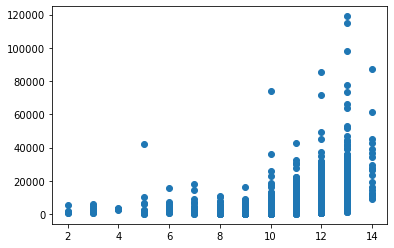

In [57]:
twitter_archive_master.head()
x = twitter_archive_master['rating_numerator']
y = twitter_archive_master['favorite_count']
plt.scatter(x, y)

Is there a relationship between the number of retweets and rating?

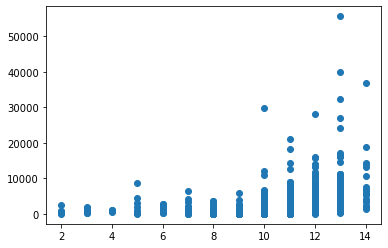

In [58]:
twitter_archive_master.head()
x = twitter_archive_master['rating_numerator']
y = twitter_archive_master['retweet_count']
plt.scatter(x, y)

Which dog is our favorite?

In [59]:
# we only care about dogs with high probability (greater than 0.95) that dog is of type p1
img_pred_dog = img_pred_clean[img_pred_clean.p1_conf.astype(float) > 0.95].copy()
# merge twitter_master_archive and our predicted dog types
fav_dogs = img_pred_dog.merge(twitter_archive_master, how='inner', on='id')

In [67]:
# which dog type is most popular?
fav_dogs[fav_dogs.favorite_count == fav_dogs.favorite_count.max()]['p1'].values[0]

'samoyed'

In [60]:
# get jpg_url of our favorite dog
url = fav_dogs[fav_dogs.favorite_count == fav_dogs.favorite_count.max()]['jpg_url'].values[0]

In [61]:
# get request object for image
r = requests.get(url)

In [62]:
# Convert raw bytes to image and resize to thumbnail
b = BytesIO(r.content)
size = 350, 350
img = Image.open(b)
img.thumbnail(size)
img.save("fav_dog.thumbnail", "JPEG")

In [65]:
# Display favorite dog
img.show()

In [68]:
# try again with p1 of 0.90
img_pred_dog = img_pred_clean[img_pred_clean.p1_conf.astype(float) > 0.90].copy()
# merge twitter_master_archive and our predicted dog types
fav_dogs = img_pred_dog.merge(twitter_archive_master, how='inner', on='id')

# which dog type is most popular?
print(fav_dogs[fav_dogs.favorite_count == fav_dogs.favorite_count.max()]['p1'].values[0])

# get jpg_url of our favorite dog
url = fav_dogs[fav_dogs.favorite_count == fav_dogs.favorite_count.max()]['jpg_url'].values[0]

# get request object for image
r = requests.get(url)

# Convert raw bytes to image and resize to thumbnail
b = BytesIO(r.content)
size = 350, 350
img2 = Image.open(b)
img2.thumbnail(size)
img2.save("fav_dog2.thumbnail", "JPEG")

french_bulldog


In [69]:
# Display favorite dog
img2.show()

What are the most popular dog names?

In [64]:
# Most popular dog names
dict(twitter_archive_master.name.value_counts())

{'Cooper': 10,
 'Lucy': 10,
 'Charlie': 10,
 'Oliver': 10,
 'Tucker': 9,
 'Penny': 9,
 'Sadie': 8,
 'Lola': 8,
 'Winston': 8,
 'Daisy': 7,
 'Toby': 7,
 'Koda': 6,
 'Oscar': 6,
 'Bo': 6,
 'Bella': 6,
 'Bailey': 6,
 'Jax': 6,
 'Stanley': 6,
 'Leo': 5,
 'Bentley': 5,
 'Scout': 5,
 'Dave': 5,
 'Rusty': 5,
 'Buddy': 5,
 'Louis': 5,
 'Chester': 5,
 'Milo': 5,
 'an': 5,
 'Boomer': 4,
 'Chip': 4,
 'Finn': 4,
 'one': 4,
 'Cassie': 4,
 'Maggie': 4,
 'Clarence': 4,
 'Gary': 4,
 'Alfie': 4,
 'George': 4,
 'Archie': 4,
 'Jack': 4,
 'Brody': 4,
 'Larry': 4,
 'Jeffrey': 4,
 'Bear': 4,
 'Scooter': 4,
 'Winnie': 4,
 'Phil': 4,
 'very': 4,
 'Duke': 4,
 'Clark': 4,
 'Dexter': 4,
 'Derek': 4,
 'Oakley': 4,
 'Jerry': 4,
 'Gus': 4,
 'Reggie': 3,
 'Wallace': 3,
 'Shadow': 3,
 'Sunny': 3,
 'Moose': 3,
 'Ruby': 3,
 'Max': 3,
 'Doug': 3,
 'Walter': 3,
 'just': 3,
 'Gizmo': 3,
 'Steven': 3,
 'Zoey': 3,
 'Vincent': 3,
 'Ellie': 3,
 'Waffles': 3,
 'Earl': 3,
 'Rosie': 3,
 'Ted': 3,
 'Mia': 3,
 'Hank': 3,
 'Beau': 